# Robot类

在这个项目中，我们将在2D网格世界中定位一个机器人。实时定位与地图构建（SLAM）的基础是从机器人的传感器和运动中收集信息，然后使用有关测量和运动的信息来重新构建一个该世界的地图。

### 不确定性

通过之前的学习，你知道了机器人运动和传感器都存在一些与之相关的不确定性。例如，想象有一辆汽车正在一个山坡上下山，车速表读数可能会高估汽车上坡的速度，并低估汽车下坡的速度，因为它无法完全解释重力。同样，我们无法精确地预测机器人的*运动* ，因为机器人可能会略微超越或未到达目标位置。

在这个notebook中，我们要看一下你很快要看到的 SLAM notebook *一部分*中的`robot` 类。首先，我们要创建一个机器人并将使其在一个2D网格世界中运动。然后，**你的任务是为这个机器人定义一个`sense`函数，使其能够感知到给定世界中的地标！**非常重要的一点是，要了解这个机器人如何运动、感知以及它如何跟踪在2D网格世界中看到的不同地标，这样你可以使用它的运动和传感器数据。

---

在开始分析机器人运动之前，首先需要加载资源并定义`robot`类。你可以看到此类初始化机器人的位置并添加运动不确定性的度量。之后，你还会看到尚未实现的`sense()`函数。稍后，你将在此notebook中了解相关的更多信息。

In [18]:
# import some resources
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [19]:
# the robot class
class robot:

    # --------
    # init: 
    #   creates a robot with the specified parameters and initializes 
    #   the location (self.x, self.y) to the center of the world
    #
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    # returns a positive, random float
    def rand(self):
        return random.random() * 2.0 - 1.0


    # --------
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    # --------
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #
    
    ## TODO: complete the sense function
    def sense(self):
        ''' This function does not take in any parameters, instead it references internal variables
            (such as self.landamrks) to measure the distance between the robot and any landmarks
            that the robot can see (that are within its measurement range).
            This function returns a list of landmark indices, and the measured distances (dx, dy)
            between the robot's position and said landmarks.
            This function should account for measurement_noise and measurement_range.
            One item in the returned list should be in the form: [landmark_index, dx, dy].
            '''
           
        measurements = []
        
        ## TODO: iterate through all of the landmarks in a world
        for x in range(len(self.landmarks)):
        ## TODO: For each landmark
        ## 1. compute dx and dy, the distances between the robot and the landmark
            dx = self.x - self.landmarks[x][0] + self.rand() * self.measurement_noise
            dy = self.y - self.landmarks[x][1] + self.rand() * self.measurement_noise
        ## 2. account for measurement noise by *adding* a noise component to dx and dy
        ##    - The noise component should be a random value between [-1.0, 1.0)*measurement_noise
        ##    - Feel free to use the function self.rand() to help calculate this noise component
        ##    - It may help to reference the `move` function for noise calculation
        ## 3. If either of the distances, dx or dy, fall outside of the internal var, measurement_range
        ##    then we cannot record them; if they do fall in the range, then add them to the measurements list
        ##    as list.append([index, dx, dy]), this format is important for data creation done later
            measurements.append([x,dx,dy])
        ## TODO: return the final, complete list of measurements
        return measurements

    
    # --------
    # make_landmarks: 
    # make random landmarks located in the world
    #
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks
    
    
    # called when print(robot) is called; prints the robot's location
    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


## 定义一个世界和一个机器人

接下来，让我们实例化一个机器人对象。正如你在上面的 `__init__`中所看到的，robot类接收了许多参数，包括该世界的尺寸数据和一些指示机器人的感知与运动能力的值。

在下一个例子中，我们会定义一个10x10平方的小世界，即该世界一半的测量范围，以及较小的运动与测量噪声值。这些值通常会大约10倍，但我们希望在小范围内证明这种行为。当然了，你也可以自由更改这些值，并注意观察机器人移动时会发生什么！

In [20]:
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# print out the location of r
print(r)

Robot: [x=5.00000 y=5.00000]


## 将该世界可视化

在给定的示例中，我们可以看到，机器人在（x，y）=（5.0,5.0）处，正好位于10x10世界的中心，这正是我们所期望的！

然而，如果没有可视化网格，我们很难知道这个机器人是处于该世界的中心。因此，在下一个单元格中，我们提供了一个辅助性可视化函数`display_world`，它将在一个绘图中显示一个网格世界并在我们机器人的位置`r`绘制一个红色`o`。有关此函数如何工作的详细信息，你可以在home目录的`helpers.py`文件中找到；另外，此`helpers.py`文件中的任何内容都不需要做更改。

Robot: [x=5.00000 y=5.00000]


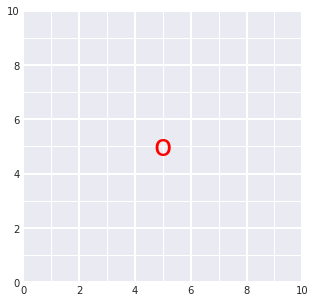

In [21]:
# import helper function
from helpers import display_world

# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# call display_world and display the robot in it's grid world
print(r)
display_world(int(world_size), [r.x, r.y])

## 运动

现在，你可以真实地想像出该机器人在这个小世界中的位置！接下来，我们需要调用机器人的`move`函数。我们会要求它移动一段距离`(dx, dy)`，然后，通过机器人的位置`o`和输出的位置`r`，我们会看到这次移动并不精确，没有达到预定的位置。

尝试多次更改`dx`和`dy`的值和/或运行此单元格，了解机器人是如何移动的，以及机器人运动的不确定性会如何在多个运动中累积。

#### 如果`dx` = 1，机器人是否*正好*向右移动了一个位置？如果`dx` = -1，会怎样呢？如果你试图让机器人移动到该世界的边缘位置，会发生什么情况？

Robot: [x=6.07057 y=6.87384]


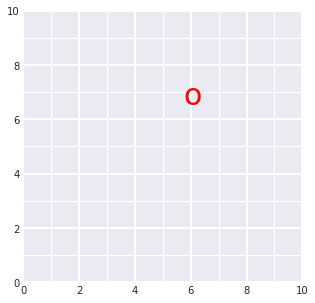

In [22]:
# choose values of dx and dy (negative works, too)
dx = 1
dy = 2
r.move(dx, dy)

# print out the exact location
print(r)

# display the world after movement, not that this is the same call as before
# the robot tracks its own movement
display_world(int(world_size), [r.x, r.y])

## 地标

接下来，让我们创建地标，这些地标是地图中可测量的地理特征。你可以将地标视为知名建筑物或较小的物体，如树木、岩石或其他特征。

我们的robot类有一个`make_landmarks`函数，它会随机生成指定地标数量的位置。尝试更改`num_landmarks`或多次运行此单元格，查看这些地标出现的位置。我们必须将这些位置作为第三个参数传递给`display_world`函数，并访问地标位置列表，这个类似于我们寻找机器人位置`r.landmarks`的方法。

每个地标在网格世界中都显示为紫色`x` ，我们还在此单元格的末尾输出了这些地标的确切位置`[x, y]`。

Robot: [x=6.07057 y=6.87384]


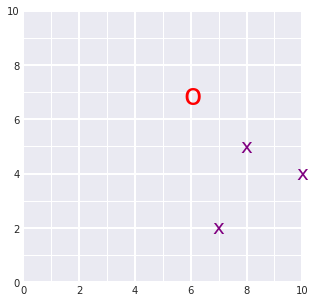

Landmark locations [x,y]:  [[8, 5], [10, 4], [7, 2]]


In [23]:
# create any number of landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

## Sense 函数

有了可以感知的地标之后，我们需要告诉我们的机器人，使其*尝试*去感知它们离它有多远。你可以在我们的robot类中编写`sense`函数。

 `sense`函数仅使用内部类参数，并返回测量/感测到的x和y距离列表，该列表指向它在指定的`measurement_range`内感知到的地标。

### TODO：实现`sense`函数 

按照上面类代码中的`##TODO's`来完成robot类的`sense`函数。测试完代码后，请**将完整的`sense` 代码复制到home目录中的 `robot_class.py` 文件中。**将这个完整的代码放在`robot_class` Python文件中之后，我们就可以在以后的notebook中引用这个类。

测量的格式为`[i, dx, dy]`，其中`i`是指地标索引（0,1,2，...），`dx`和`dy` 是机器人位置（x，y）与地标位置（x，y）之间的测量距离。由于我们的sense函数具有一些相关的测量噪声，因此该距离并不是完美精确的。

---

在下面单元格中的示例中，我们给机器人指定的范围是`5.0`，因此任何位于机器人位置范围内的地标都应该出现在测量列表中。但是，并非所有地标都保证会出现在我们的可见范围内，因此该列表的长度是可变的。

*注意：机器人的位置通常被称为**姿势**或`[Pxi, Pyi]`，而地标位置通常写为`[Lxi, Lyi]`。你会在下一个notebook中看到这种表示方法。*

In [24]:
# try to sense any surrounding landmarks
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)

[[0, -2.0712366229462083, 2.021782739438379], [1, -4.126653625868939, 2.95971219800828], [2, -0.9493670012562034, 4.732144610765205]]


**请参阅上面的网格地图。这些测量对你有意义吗？所有地标是否都囊括在了此列表中？为什么会全部囊括/为什么没有囊括？**

---
## 数据

#### 把所有数据放在一起

为了执行SLAM，我们将在规定时间段内按顺序收集一系列机器人传感器测量值和运动值。然后，将仅使用这些数据来重建包含该机器人和地标位置的该世界的地图。你可以把SLAM想象成我们在这个notebook上所做的事情，只是把顺序反过来而已。请注意，在这里，你要做的不是去定义该世界和机器人并创建运动与传感器数据，而是由你使用运动和传感器测量数据来重建这个世界！

在下一个notebook中，你将会看到一个名为`data`的结构中列出的运动与测量值列表（用于重建世界）。这是一个以特定顺序保存传感器测量值和运动的数组，当你需要提取此数据并形成约束矩阵和向量时，它会非常有用。

`data` 是通过下面的一系列时间步骤构建而成的：

In [25]:
data = []

# after a robot first senses, then moves (one time step)
# that data is appended like so:
data.append([measurements, [dx, dy]])

# for our example movement and measurement
print(data)

[[[[0, -2.0712366229462083, 2.021782739438379], [1, -4.126653625868939, 2.95971219800828], [2, -0.9493670012562034, 4.732144610765205]], [1, 2]]]


In [26]:
# in this example, we have only created one time step (0)
time_step = 0

# so you can access robot measurements:
print('Measurements: ', data[time_step][0])

# and its motion for a given time step:
print('Motion: ', data[time_step][1])

Measurements:  [[0, -2.0712366229462083, 2.021782739438379], [1, -4.126653625868939, 2.95971219800828], [2, -0.9493670012562034, 4.732144610765205]]
Motion:  [1, 2]


### 关于robot类的最后一点说明

在继续本系列最后一个notebook之前，请确保你已将最终完成的`sense`函数复制到home目录中的`robot_class.py`文件中。我们将在最终实现SLAM时使用此文件！